In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
%matplotlib inline

In [2]:
df=pd.read_csv('full_data.csv')

In [3]:
df=df.iloc[:len(df)//7]

In [4]:
df['stroke'].sum()

208

In [5]:
cat_col=['gender','ever_married','work_type','Residence_type','smoking_status']
cont_cols=['age','avg_glucose_level','bmi','hypertension','heart_disease']
y_col=['stroke']

In [6]:
for cat in cat_col:
    df[cat]=df[cat].astype('category')

In [7]:
df.dtypes

gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
dtype: object

In [8]:
conts=np.stack([df[col].values for col in cont_cols],axis=1)
cats=np.stack([df[cat].cat.codes.values for cat in cat_col],axis=1)

In [9]:
cats

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 0, 2],
       [0, 1, 1, 1, 3],
       ...,
       [0, 1, 1, 1, 1],
       [0, 1, 2, 1, 2],
       [1, 0, 3, 1, 0]], dtype=int8)

In [10]:
conts=torch.tensor(conts,dtype=torch.float)
cats=torch.tensor(cats,dtype=torch.int64)

In [11]:
y=torch.tensor(df[y_col].values,dtype=torch.int64).flatten()
y[:5]

tensor([1, 1, 1, 1, 1])

In [12]:
emb_szs=[(size,min(50,(size+1)//2)) for size in [len(df[col].cat.categories) for col in cat_col]]

In [13]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x
    
    

In [14]:
torch.manual_seed(53)
model=TabularModel(emb_szs,conts.shape[1],2,[200,150,100],p=0.3)

In [15]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
import time
stt=time.time()
epochs=1000
losses=[]

for i in range(epochs):
    i+=1
    
    y_pred=model(cats,conts)
    loss=criterion(y_pred,y)
    losses.append(loss.item())
    if i%50==1:
        print(f'epoch: {i} loss is {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration=time.time()-stt
print(f'Training took {duration/60} minutes')

epoch: 1 loss is 0.7710157632827759
epoch: 51 loss is 0.49296456575393677
epoch: 101 loss is 0.4433494508266449
epoch: 151 loss is 0.38872191309928894
epoch: 201 loss is 0.37917360663414
epoch: 251 loss is 0.37812119722366333
epoch: 301 loss is 0.33641770482063293
epoch: 351 loss is 0.3271421790122986
epoch: 401 loss is 0.33550697565078735
epoch: 451 loss is 0.3126237094402313
epoch: 501 loss is 0.2611858546733856
epoch: 551 loss is 0.3082546293735504
epoch: 601 loss is 0.2674769163131714
epoch: 651 loss is 0.25409412384033203
epoch: 701 loss is 0.25224369764328003
epoch: 751 loss is 0.2540302574634552
epoch: 801 loss is 0.2593945860862732
epoch: 851 loss is 0.2375403344631195
epoch: 901 loss is 0.23216822743415833
epoch: 951 loss is 0.21154122054576874
Training took 0.314991553624471 minutes


Text(0, 0.5, 'loss')

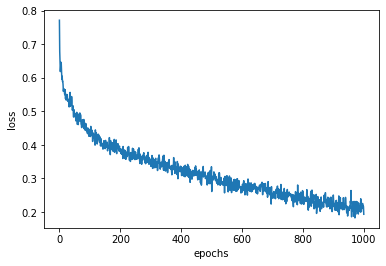

In [17]:
plt.plot(range(epochs),losses)
plt.xlabel('epochs')
plt.ylabel('loss')

In [18]:
dt1=pd.read_csv('full_filled_stroke_data (1).csv')

In [19]:
dt2=df.iloc[len(df)//7:]
dtest=pd.concat([dt1,dt2])

In [20]:
for cat in cat_col:
    dtest[cat]=dtest[cat].astype('category')

In [21]:
conts=np.stack([dtest[col].values for col in cont_cols],axis=1)
cats=np.stack([dtest[cat].cat.codes.values for cat in cat_col],axis=1)

In [22]:
conts=torch.tensor(conts,dtype=torch.float)
cats=torch.tensor(cats,dtype=torch.int64)

In [23]:
y=torch.tensor(dtest[y_col].values,dtype=torch.int64).flatten()
y[:5]

tensor([1, 1, 1, 1, 1])

In [24]:
with torch.no_grad():
    y_val=model(cats,conts)
    
    loss=criterion(y_val,y)

In [25]:
loss

tensor(0.4498)

In [26]:

correct = 0
print(f'ARGMAX  Y_TEST')
for i in range(len(y)):
    print(f'{y_val[i].argmax():^7}{y[i]:^7}')
    if y_val[i].argmax().item() == y[i]:
        correct += 1
print(f'\n{correct} out of {len(y)} = {100*correct/len(y):.2f}% correct')

ARGMAX  Y_TEST
   0      1   
   0      1   
   1      1   
   1      1   
   1      1   
   1      1   
   0      1   
   1      1   
   1      1   
   0      1   
   0      1   
   0      1   
   0      1   
   1      1   
   0      1   
   0      1   
   1      1   
   1      1   
   0      1   
   1      1   
   0      1   
   0      1   
   0      1   
   0      1   
   1      1   
   1      1   
   1      1   
   0      1   
   0      1   
   0      1   
   1      1   
   1      1   
   1      1   
   1      1   
   1      1   
   1      1   
   0      1   
   1      1   
   0      1   
   1      1   
   0      0   
   0      0   
   0      0   
   1      0   
   1      0   
   0      0   
   0      0   
   0      0   
   0      0   
   0      0   
   0      0   
   0      0   
   1      0   
   0      0   
   0      0   
   0      0   
   0      0   
   0      0   
   0      0   
   1      0   
   0      0   
   1      0   
   0      0   
   0      0   
   0      0   
   1      